In [56]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.offsetbox import AnchoredText
from numpy.random import SeedSequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from pyselect.datasets import make_gregorova_se1, make_gregorova_se2, make_jordan_se1
from pyselect.model import RFFNet

# Solvers

In [3]:
def prox_2_squared(x, alpha):
    "Proximal operator for l2 norm squared."
    return x / (1 + 2 * alpha)


def adam_palm(n_random_features):
    torch.manual_seed(SEED)
    model = RFFNet(dims=[n_features, n_random_features, 1])

    optim_linear = torch.optim.Adam(model.linear.parameters(), lr=LR)
    optim_rff = torch.optim.Adam(model.rff.parameters(), lr=LR)

    no_improvement_count = 0
    best_val_loss = torch.Tensor([float("Inf")])

    history = []

    for epoch in range(N_EPOCHS):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // BATCH_SIZE):
            batch = indices[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
            pred = model(X_train[batch])

            loss = CRITERION(pred, y_train[batch])

            optim_linear.zero_grad()
            loss.backward()
            optim_linear.step()

            with torch.no_grad():
                curr_lr = optim_linear.param_groups[0]["lr"]
                model.linear.weight.data = prox_2_squared(
                    model.linear.weight.data, ALPHA * curr_lr
                )

        for i in range(train_size // BATCH_SIZE):
            batch = indices[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
            pred = model(X_train[batch])

            loss = CRITERION(pred, y_train[batch])

            optim_rff.zero_grad()
            loss.backward()
            optim_rff.step()

        with torch.no_grad():
            val_loss = CRITERION(model(X_val), y_val)
            history.append(val_loss)

        if val_loss < MIN_DELTA_FRACTION * best_val_loss:
            best_model_state_dict = model.state_dict()
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count == N_ITER_NO_CHANGE:
            break

    return history

## Randomness

In [4]:
seed_sequence = SeedSequence(entropy=0)

In [5]:
SEED = seed_sequence.generate_state(1)[0]

## Data

In [6]:
n_samples = 6 * 10 ** 3
train_size = 5 * 10 ** 3

## Run

In [7]:
n_random_features = 200

In [16]:
N_EPOCHS = 100
LR = 1e-2
BATCH_SIZE = 250
ALPHA = 1e-1
CRITERION = torch.nn.MSELoss()
MIN_DELTA_FRACTION=1.0
N_ITER_NO_CHANGE=10

In [17]:
jse1 = []
gse1 = []
gse2 = []

In [18]:
features = np.arange(50, 1200, 50)

In [19]:
for loss, gen in zip([jse1, gse1, gse2] ,[make_jordan_se1, make_gregorova_se1, make_gregorova_se2]):
    X, y = gen(n_samples=n_samples, random_state=SEED)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, train_size=train_size, random_state=SEED
    )
    n_features = X.shape[1]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    X_train = torch.FloatTensor(X_train)
    X_val = torch.FloatTensor(X_val)
    y_train = torch.FloatTensor(y_train)
    y_val = torch.FloatTensor(y_val)
    
    for f in tqdm(features):
        hist = adam_palm(f)
        loss.append(hist[-1])
    
    

100%|██████████| 23/23 [06:04<00:00, 15.84s/it]


## Plot

In [20]:
CMAP = plt.cm.plasma
CMAP_R = plt.cm.plasma_r
COLORS = [CMAP(i / 3.0) for i in range(4)]

In [21]:
COLOR_0 = COLORS[0]
COLOR_1 = COLORS[1]
COLOR_2 = COLORS[2]

In [27]:
TEXTWIDTH = 3.25063
FONTSIZE = 6

In [28]:
def setup():
    matplotlib.rcParams.update({"font.size": FONTSIZE})  # controls default text sizes
    matplotlib.rcParams.update({"axes.titlesize": FONTSIZE})  # fontsize of the axes title
    matplotlib.rcParams.update({"axes.labelsize": FONTSIZE})  # fontsize of the x and y labels
    matplotlib.rcParams.update({"axes.formatter.use_mathtext": True})  # use scientific notation for axes with pretty formatting
    matplotlib.rcParams.update({"axes.formatter.useoffset": True}) #
    matplotlib.rcParams.update({"axes.formatter.limits": [0, 0]})  
    matplotlib.rcParams.update({"xtick.labelsize": FONTSIZE})  # fontsize of the tick labels
    matplotlib.rcParams.update({"ytick.labelsize": FONTSIZE})  # fontsize of the tick labels
    matplotlib.rcParams.update({"legend.fontsize": FONTSIZE})  # legend fontsize
    matplotlib.rcParams.update({"figure.titlesize": FONTSIZE})  # fontsize of the figure title
    matplotlib.rcParams.update({"figure.dpi": 300})
    matplotlib.rcParams.update({"savefig.dpi": 300})

In [29]:
setup()

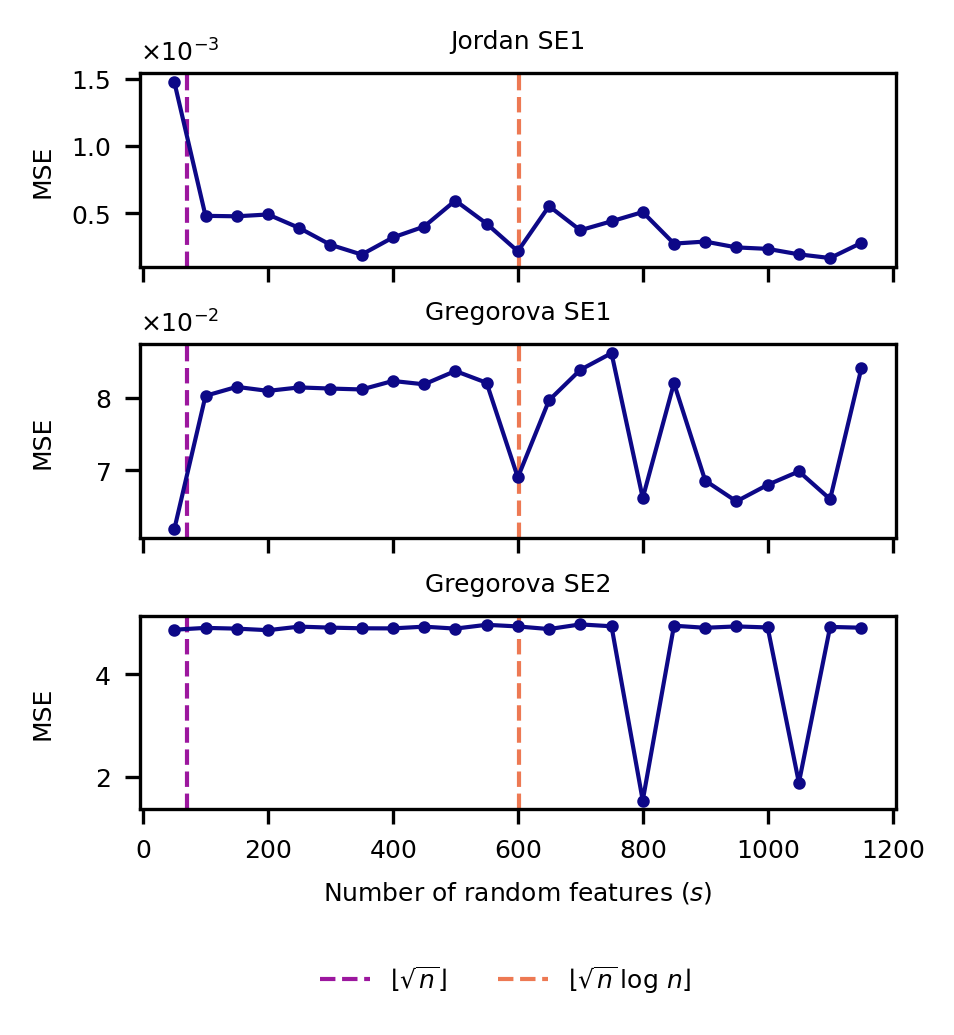

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(TEXTWIDTH, TEXTWIDTH))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

ax1.plot(features, jse1, 'o-', lw=1, ms=2, color=COLOR_0)
ax1.set_title("Jordan SE1")
ax1.axvline(x=int(np.sqrt(train_size)), lw=1, linestyle="dashed", color=COLOR_1, zorder=-1, label=r"$\lfloor \sqrt{n} \rfloor$")
ax1.axvline(x=int(np.sqrt(train_size)*np.log(train_size)), lw=1, linestyle="dashed", color=COLOR_2, zorder=-1, label=r"$\lfloor \sqrt{n} \, \log \,n \rfloor$")
ax1.set_ylabel("MSE")
#anchored_text = AnchoredText(r"$n = 5 \times 10^4$",frameon=False, loc="upper left", bbox_to_anchor=(1.0, 1.0), bbox_transform=ax1.transAxes)
#ax1.add_artist(anchored_text)

ax2.plot(features, gse1,'o-', lw=1, ms=2, color=COLOR_0)
ax2.set_title("Gregorova SE1")
ax2.axvline(x=int(np.sqrt(train_size)), lw=1, linestyle="dashed", color=COLOR_1, zorder=-1)
ax2.axvline(x=int(np.sqrt(train_size)*np.log(train_size)), lw=1, linestyle="dashed", color=COLOR_2, zorder=-1)
ax2.set_ylabel("MSE")

ax3.plot(features, gse2, 'o-', lw=1, ms=2, color=COLOR_0)
ax3.set_title("Gregorova SE2")

ax3.set_xlabel(r"Number of random features ($s$)")
ax3.ticklabel_format(style="plain", axis="x")
ax3.axvline(x=int(np.sqrt(train_size)), lw=1, linestyle="dashed", color=COLOR_1, zorder=-1)
ax3.axvline(x=int(np.sqrt(train_size)*np.log(train_size)), lw=1, linestyle="dashed", color=COLOR_2, zorder=-1)
ax3.set_ylabel("MSE")

fig.align_ylabels()

lines_labels = [ax1.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=9, bbox_to_anchor=(0.5, -0.01), ncols=2, frameon=False)

plt.savefig("../figures/validation/random_features.pdf", bbox_inches="tight")

plt.show()